In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from clustergram import Clustergram
import shap
from scipy import spatial
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("C:/Users/hp/Downloads/MClip-rawfortest-8-23-21.xlsx")
df_temp = df.copy()

In [3]:
# considering only those columns who have null value les than 30%
null_count = df.isna().sum().to_dict()
col=[]
for i in null_count:
    if (null_count[i]/389)<0.30:
        col.append(i)

In [4]:
for i in df:
    if i not in col:
        df.drop([i],axis=1,inplace=True)

In [5]:
# Finding categorical and numeric column
cat = [] 
reg = []
for i in df:
    if type(df[i][0]) == str:
        cat.append(i)
    else:
        reg.append(i)

In [6]:
# Handling missing values
cat1=[]
for i in df:
    if df[i].dtype == 'object':
        cat1.append(i)
        df[i].fillna(statistics.mode(list(df[i])), inplace = True)
    else:
        df[i].fillna(np.mean(df[i]),inplace=True)

label_encoder_dict=dict()
for i in cat1:
    label_encoder_dict[i] = preprocessing.LabelEncoder()
    df[i]= label_encoder_dict[i].fit_transform(df[i])

In [7]:
import statistics 
# Considering the features with variance > 0.1 ==> 40 columns stored in col1 list
# 14 numerical column + 26 categorical column (Total 40 columns)
col1=[]
for i in col:
    if statistics.variance(df[i]) > 0.1:
        col1.append(i)

In [8]:
for i in df:
    if i not in col1:
        df.drop([i],axis=1,inplace=True)

In [9]:
# Removing columns with high correlation (i.e. above 0.8)
corr = df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]

In [10]:
df = df[selected_columns]

In [11]:
columns=['age','KCCQ12_Overall','Height','Weight','PreProcHgb','PreProcCreat','NTproBNP','FEV1','PostProcHgb',
'PostProcCreat','F_Post_MVMeanGrad','F_Post_LVISD','F_Post_LVIDD','F_Post_LVESV','F_Post_LVEDV','bmi']

for i in columns:
    if i not in df.columns:
        df[i]=df_temp[i]

In [16]:
# Handling missing values
cat1=[]
for i in df:
    if df[i].dtype == 'object':
        cat1.append(i)
        df[i].fillna(statistics.mode(list(df[i])), inplace = True)
    else:
        df[i].fillna(np.mean(df[i]),inplace=True)

label_encoder_dict=dict()
for i in cat1:
    label_encoder_dict[i] = preprocessing.LabelEncoder()
    df[i]= label_encoder_dict[i].fit_transform(df[i])

In [17]:
df.shape

(389, 47)

In [18]:
# Finding categorical and numeric column
cat = [] 
reg = []
for i in df:
    if type(df[i][0]) == str:
        cat.append(i)
    else:
        reg.append(i)

In [19]:
len(cat) 
# As there are no categorical column present in the common list(in p-value table and df column)
# as well as in the important columns list (acc to pre-processing)
# We can directly use it for clustering as all columns are numerical space only

0

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.02353954315185547 seconds.
K=3 fitted in 0.021005868911743164 seconds.
K=4 fitted in 0.02201247215270996 seconds.


<AxesSubplot:xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

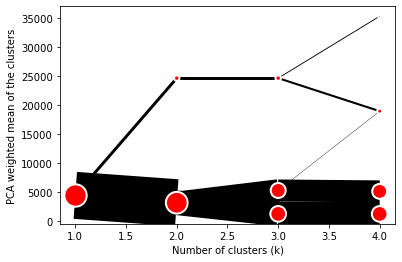

In [20]:
cgram_test = Clustergram(range(1, 5))
cgram_test.fit(df)
cgram_test.plot()

In [21]:
def elbow_plot(df_new):
    Sum_of_squared_distances = []
    K = range(1,10)
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df_new)
        Sum_of_squared_distances.append(kmeans.inertia_)
    plt.plot(K,Sum_of_squared_distances,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Sum of squared distances/Inertia') 
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [22]:
def silhouette_plot(df_new):
    range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
    silhouette_avg = []
    for num_clusters in range_n_clusters:
        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(df_new)
        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg.append(silhouette_score(df_new, cluster_labels))
    plt.plot(range_n_clusters,silhouette_avg,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

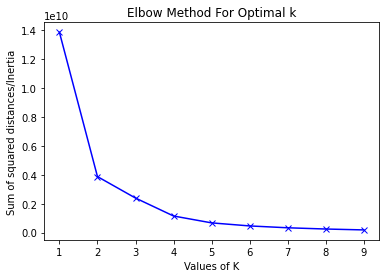

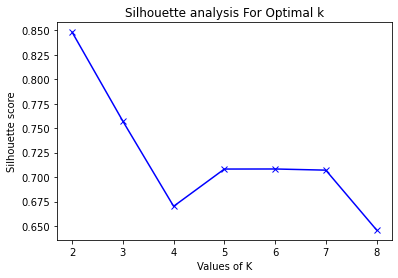

Training Accuracy : 0.6701085988424209


In [23]:
# Finding optimal cluster number
elbow_plot(df)
silhouette_plot(df)

# Create a k-means object
kmeans = KMeans(n_clusters=4,max_iter=1000)

# Fit the kmeans object in the dataset
kmeans.fit(df)

# Predict y_train
y_km_train = kmeans.predict(df)
print("Training Accuracy :",silhouette_score(df, y_km_train))

In [24]:
#df.to_csv("df_temp.tsv", sep="\t", index=False, header=False)

labels = pd.DataFrame()
labels["labels"] = y_km_train
labels.to_csv("labels_pca.tsv", sep="\t", index=False, header=False)

In [25]:
labels["labels"].value_counts()

0    191
2    172
3     19
1      7
Name: labels, dtype: int64

In [26]:
# # Finding the cluster centers
# centroids  = kmeans.cluster_centers_
# centroid_data = pd.DataFrame(centroids)
# centroid_data

In [27]:
#df = df_copy.copy()
df["labels"]=labels["labels"]
df_0 = df[df["labels"]==0]
df_1 = df[df["labels"]==1]
df_2 = df[df["labels"]==2]
df_3 = df[df["labels"]==3]

In [28]:
df_0.drop(["labels"],axis=1,inplace=True)
df_1.drop(["labels"],axis=1,inplace=True)
df_2.drop(["labels"],axis=1,inplace=True)
df_3.drop(["labels"],axis=1,inplace=True)

In [29]:
l0=[]
l1=[]
l2=[]
l3=[]

for i in df_0:
    l0.append(np.mean(df_0[i]))
    l1.append(np.mean(df_1[i]))
    l2.append(np.mean(df_2[i]))
    l3.append(np.mean(df_3[i]))

In [30]:
l=[]
l.append(l0)
l.append(l1)
l.append(l2)
l.append(l3)
df.drop(['labels'],axis=1,inplace=True)
centroid = pd.DataFrame(l)
centroid.columns = df.columns
centroid

,age,Height,Weight,PreProcHgb,PreProcCreat,NTproBNP,bmi,meas0010 = Left Ventricular Internal End\n Diastolic Dimension by 2-D (category: LVEDD),meas0156 = Diastolic Blood \nPressure (category: BP),meas0157 = Systolic Blood\n Pressure (category: BP),...,imp50805 = Aortic Stenosis,KCCQ12_Overall,FEV1,PostProcHgb,PostProcCreat,F_Post_MVMeanGrad,F_Post_LVISD,F_Post_LVIDD,F_Post_LVESV,F_Post_LVEDV
0,78.016467,168.158115,79.975916,12.828076,1.237803,1270.167539,27.979100,52.994783,67.728854,126.410050,...,1.874346,45.778801,77.075380,11.156112,1.204211,4.875903,3.874160,5.425298,79.887152,152.436253
1,75.352250,169.285714,79.014286,10.914286,3.942857,35336.000000,27.077417,57.105745,65.535344,125.022091,...,1.857143,44.139150,78.222031,9.442857,4.054554,5.022432,3.850695,5.396279,80.689189,152.864865
2,79.346655,168.973837,75.093605,12.007522,1.568103,5154.594754,26.301444,54.123624,68.764304,121.356210,...,1.959302,46.704928,72.459162,10.618412,1.563739,4.755814,4.024810,5.544401,81.772077,153.419862
3,73.700360,165.894737,75.100000,10.363158,2.347368,18978.789474,28.283674,53.244240,69.815516,124.384699,...,1.947368,39.893797,68.551046,9.194737,2.584211,5.573293,3.917746,5.457099,78.948791,152.149360


In [31]:
for i in range(4):
    for j in range(i+1,4):
        print("cosine distance between centroid ",i," and centroid ",j," is")
        print(spatial.distance.cosine(list(centroid.iloc[i]),list(centroid.iloc[j])))

cosine distance between centroid  0  and centroid  1  is
0.029623657234365663
cosine distance between centroid  0  and centroid  2  is
0.017982666957901294
cosine distance between centroid  0  and centroid  3  is
0.027778497035475636
cosine distance between centroid  1  and centroid  2  is
0.0014641840456600663
cosine distance between centroid  1  and centroid  3  is
3.040618920413518e-05
cosine distance between centroid  2  and centroid  3  is
0.0010742848170776087


In [32]:
X_train, X_test, y_train, y_test = train_test_split(df,y_km_train, test_size=0.33, random_state=42)
my_model = RandomForestClassifier().fit(X_train, y_train)

In [33]:
train_score = my_model.score(X_train, y_train)
test_score = my_model.score(X_test, y_test)
print("Training score : ",train_score)
print("Test score : ",test_score)

Training score :  1.0
Test score :  0.9457364341085271


Summary plot for Cluster 0:


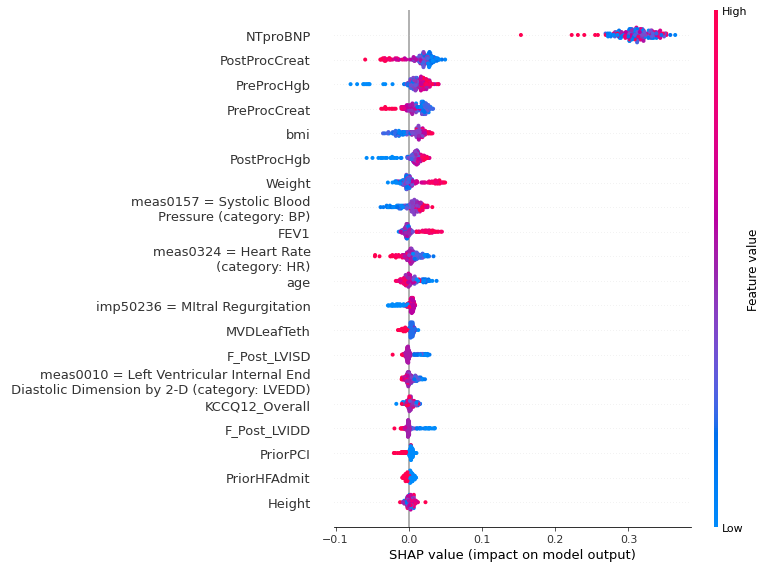

In [34]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(df_0)

print("Summary plot for Cluster 0:")
shap.summary_plot(shap_values[0], df_0)

Summary plot for Cluster 1:


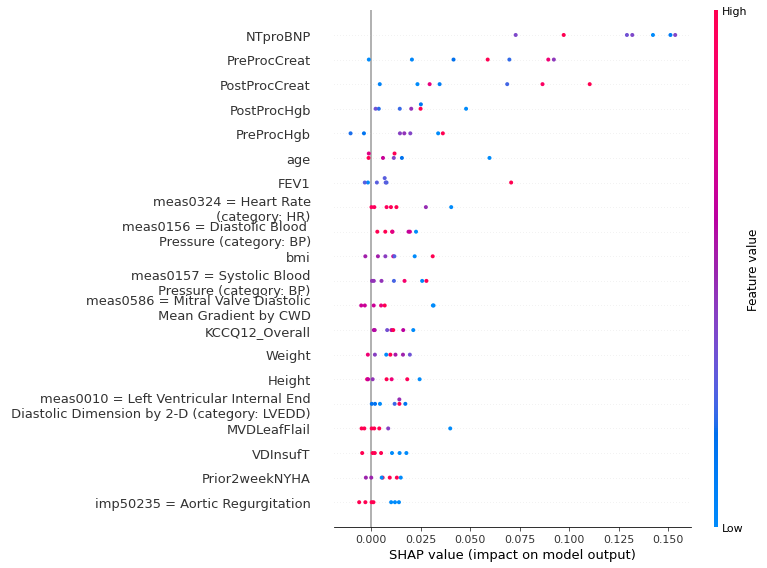

In [35]:
shap_values = explainer.shap_values(df_1)

print("Summary plot for Cluster 1:")
shap.summary_plot(shap_values[1], df_1)

Summary plot for Cluster 2:


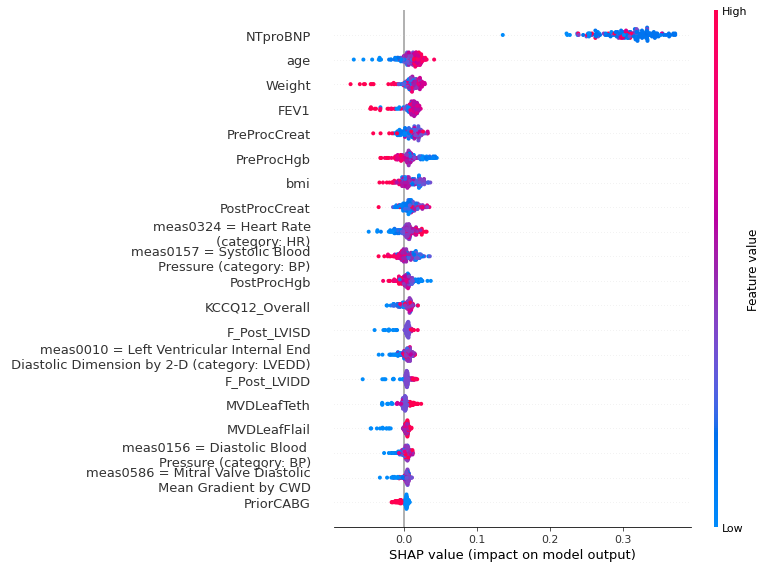

In [36]:
shap_values = explainer.shap_values(df_2)

print("Summary plot for Cluster 2:")
shap.summary_plot(shap_values[2], df_2)

Summary plot for Cluster 3:


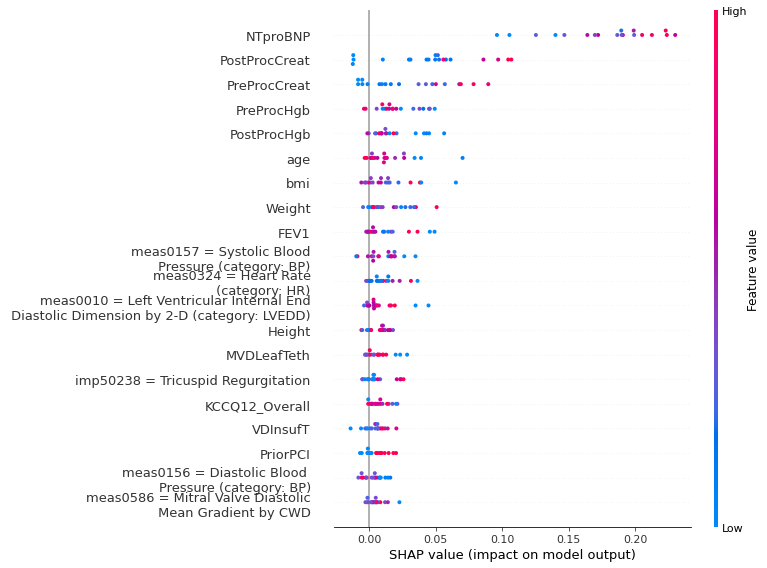

In [37]:
shap_values = explainer.shap_values(df_3)

print("Summary plot for Cluster 3:")
shap.summary_plot(shap_values[3], df_3)

In [38]:
my_model.score(df, y_km_train)

0.9820051413881749